In [23]:
import os
import sys 
import torch as tr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
sys.path.append("../")

from src.dataset import SeqDataset, pad_batch 
from src.metrics import contact_f1
from src.utils import load_config, load_model


LOG_PATH = "../logs/exp_T25_E50_20260116_221758/"
BATCH_SIZE = 4
 
checkpoint_path = os.path.join(LOG_PATH, "best_model.pt")  
config = load_config(LOG_PATH)
model = load_model(config=config, eval=True, checkpoint_path=checkpoint_path)


TEST_PATH = "../data/ArchiveII_128_random_split/test.csv"
test_dataset = SeqDataset(TEST_PATH, max_len=128)
test_loader = tr.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=pad_batch)

# Validate triangular F1 in test

In [24]:
def validate_model_triangular(model, loader, seed=42):
    device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
    model.eval()
    all_f1_scores = []
    
    print(f"Testing with triangular F1..., seed={seed}")
    tr.manual_seed(seed)
    with tr.no_grad():
        for batch_idx, batch in enumerate(loader):            
            condition = batch["outer"].to(device)
            target = batch["contact_oh"].to(device) 
            lengths = batch["length"]
            samples = model._sample(condition) 
            
            batch_scores = contact_f1(samples, target, lengths, reduce=False)
            all_f1_scores.extend(batch_scores)
            
            if batch_idx % 20 == 0:
                print(f"Batch {batch_idx}: mean F1 = {tr.mean(batch_scores):.4f}")

    total_mean_f1 = np.mean(all_f1_scores)
    return total_mean_f1, all_f1_scores
    
mean_f1, all_f1_scores = validate_model_triangular(model, test_loader, seed=42)

Testing with triangular F1..., seed=42
Batch 0: mean F1 = 0.9104
Batch 20: mean F1 = 0.9239
Batch 40: mean F1 = 1.0000
Batch 60: mean F1 = 0.9543
Batch 80: mean F1 = 1.0000


In [25]:
def validate_ensemble(model, loader):
    
    device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
    all_f1_scores = []
    for seed in range(5):
        tr.manual_seed(seed)
        
        with tr.no_grad():
            for batch_idx, batch in enumerate(loader):            
                condition = batch["outer"].to(device)
                target = batch["contact_oh"].to(device) 
                lengths = batch["length"]
                samples = model._sample(condition) 
                
                batch_scores = contact_f1(samples, target, lengths, reduce=False)
                all_f1_scores.extend(batch_scores)
                
                if batch_idx % 20 == 0:
                    print(f"Batch {batch_idx}: mean F1 = {tr.mean(batch_scores):.4f}")

        total_mean_f1 = np.mean(all_f1_scores)
    return total_mean_f1, all_f1_scores
    
mean_f1, all_f1_scores = validate_model_triangular(model, test_loader, seed=42)

Testing with triangular F1..., seed=42
Batch 0: mean F1 = 0.9104
Batch 20: mean F1 = 0.9239
Batch 40: mean F1 = 1.0000
Batch 60: mean F1 = 0.9543
Batch 80: mean F1 = 1.0000


# Ensemble generation

## Save Raw samples

In [26]:
def generate_raw_ensemble(model, loader, save_dir, num_samples=500, base_seed=42):
    """
    Genera N muestras y las guarda RAW individualmente junto con su semilla.
    
    Args:
        save_dir: Carpeta donde guardar los .pt
        base_seed: Semilla inicial. Las muestras usarán base_seed, base_seed+1, ...
    """
    model.eval()
    
    device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"Generando Raw Ensembles (N={num_samples}) en {save_dir}...")

    for batch in tqdm(loader, desc="Generando"):
        B = batch["outer"].shape[0]
        
        for i in range(B):
            # Identificador único
            seq_id = batch["id"][i] if "id" in batch else f"seq_{np.random.randint(1e6)}"
            path = os.path.join(save_dir, f"{seq_id}.pt")
            
            # Si ya existe, saltar (útil para reanudar experimentos)
            if os.path.exists(path): continue

            cond = batch["outer"][i:i+1].to(device)
            
            # Almacenamiento temporal
            sample_list = []
            used_seeds = []
            
            # Generar variando semillas controladamente
            for k in range(num_samples):
                current_seed = base_seed + k
                tr.manual_seed(current_seed) # Fijar semilla para ESTE sample
                
                with tr.no_grad():
                    # Generar y pasar a CPU float16 o int8 para ahorrar espacio
                    # Asumimos que _sample devuelve 0/1. Si devuelve prob, usar float16.
                    s = model._sample(cond).squeeze().cpu().to(tr.int8)
                    
                sample_list.append(s)
                used_seeds.append(current_seed)
            
            # Guardar Diccionario con TODO
            data = {
                "samples": tr.stack(sample_list), 
                "seeds": used_seeds,              
                "target": batch["contact_oh"][i].cpu().to(tr.int8), 
                "length": batch["length"][i]
            }
            # tr.save(data, path)

    print("Generación finalizada.")

In [28]:

generate_raw_ensemble(model, test_loader,  "raw_samples", num_samples=1, base_seed=42)

Generando Raw Ensembles (N=1) en raw_samples...


Generando: 100%|██████████| 87/87 [00:28<00:00,  3.03it/s]

Generación finalizada.


## Load RAW samples - consensus stats

In [29]:
import torch as tr
import numpy as np
from sklearn.metrics import f1_score

class SeqEnsemble:
    def __init__(self, data_path):
        """Loads the raw ensemble results of a model."""
        self.data = tr.load(data_path)
        self.samples = self.data["samples"].float() # [N, L, L] 
        self.seeds = self.data["seeds"]
        self.target = self.data["target"]
        self.length = self.data["length"]
        self.num_avail_samples = len(self.samples)
        self.path = data_path 
        if self.target.ndim == 3: self.target = self.target.argmax(dim=0)
        self.target_np = self.target.numpy()

    def evaluate_consensus(self, indices=None):
        """
        Calculates the consensus using ONLY the specified indices.
        If indices is None, uses all.
        """
        if indices is None:
            subset = self.samples
        else:
            subset = self.samples[indices]
            
        # Promedio del subset
        prob_map = subset.mean(dim=0)
        consensus = (prob_map > 0.5).numpy().astype(int)        
        return consensus    

    def get_uncertainty_map(self, indices=None):
        """Devuelve mapa de std dev para visualizar."""
        subset = self.samples if indices is None else self.samples[indices]
        return subset.std(dim=0).numpy()
    
    def _compute_f1(self, pred_matrix):
        L = int(self.length)
        rows, cols = np.triu_indices(L, k=1)
        p_flat = pred_matrix[:L, :L][rows, cols]
        r_flat = self.target_np[:L, :L][rows, cols]
        return f1_score(r_flat, p_flat, zero_division=0)

    def evaluate_single_seed(self, seed_idx):
        """Evalúa solo la muestra correspondiente a un índice (0 a N-1)."""
        pred = self.samples[seed_idx].numpy()
        return self._compute_f1(pred)
    
    def evaluate_consensus_f1(self, indices=None): 
        consensus = self.evaluate_consensus(indices)
        return self._compute_f1(consensus)
        

In [ ]:
import random 

samples = "../logs/exp_T5_E5_20260116_193102/raw_samples"   # <- cambialo
paths = [os.path.join(samples, f) 
         for f in os.listdir(samples) if f.endswith(".pt")]
paths.sort()
test_ensemble = [SeqEnsemble(p) for p in tqdm(paths, desc="Loading")] 

num_trials = 20
N_CONSENSUS = [1, 5, 10, 25]    
max_samples = min([ens.num_avail_samples for ens in test_ensemble])
chosen_seeds = {}

for k in N_CONSENSUS:
    chosen_seeds[k] = [
        random.sample(range(max_samples), k)
        for _ in range(num_trials)
    ]
        


Loading: 100%|██████████| 348/348 [00:00<00:00, 439.81it/s]


In [ ]:

def evaluate_rna_k_consensus(rna, chosen_seeds):
    row = {"seq_id": rna.path.split("/")[-1].replace(".pt","")} 
    for k in N_CONSENSUS:
        f1_list = []
        for idx in chosen_seeds[k]: 
            f1_list.append(rna.evaluate_consensus_f1(indices=idx))
        
        row[f"cons_k{k}_mean"] = np.mean(f1_list)
        row[f"cons_k{k}_std"]  = np.std(f1_list)
    return row

In [ ]:
all_stats = []
for rna_samples in tqdm(test_ensemble, desc="Evaluating"): 
    row = evaluate_rna_k_consensus(rna_samples, chosen_seeds)
    all_stats.append(row)
df_stats = pd.DataFrame(all_stats)
df_stats

Evaluating: 100%|██████████| 348/348 [00:51<00:00,  6.78it/s]


,seq_id,cons_k1_mean,cons_k1_std,cons_k5_mean,cons_k5_std,cons_k10_mean,cons_k10_std,cons_k25_mean,cons_k25_std
0,5s_Acidovorax-delafieldii-1,0.870244,0.103924,0.940997,3.755284e-02,0.953796,3.026526e-02,0.951356,1.826677e-02
1,5s_Acinetospora-crinita-1,0.941801,0.040949,0.979823,2.324426e-02,0.988732,1.144382e-02,0.995070,6.717882e-03
2,5s_Acyrthosiphon-magnoliae-1,0.948972,0.045945,0.990184,1.299308e-02,0.993284,7.425279e-03,0.997761,5.329424e-03
3,5s_Akkesiphycus-lubricum-1,0.941255,0.052755,0.981939,1.876723e-02,0.990140,9.020493e-03,0.995070,6.717882e-03
4,5s_Alcaligenes-faecalis-3,0.969556,0.020968,0.985507,2.220446e-16,0.985507,2.220446e-16,0.985507,2.220446e-16
...,...,...,...,...,...,...,...,...,...
343,tRNA_tdbR00000609-Chlamydomonas_reinhardtii-30...,0.758414,0.071137,0.784218,4.543720e-02,0.770833,1.884446e-02,0.765152,1.855674e-02
344,tRNA_tdbR00000612-Sinorhizobium_meliloti-382-T...,0.820536,0.074732,0.838933,3.449938e-02,0.858339,2.785583e-02,0.863727,4.960340e-03
345,tRNA_tdbR00000615-Nanoarchaeum_equitans-160232...,0.883435,0.093942,0.975777,4.138293e-02,0.982805,1.586725e-02,0.987805,1.219512e-02
346,tRNA_tdbR00000616-Nanoarchaeum_equitans-160232...,0.918274,0.075113,0.990997,2.138018e-02,1.000000,0.000000e+00,1.000000,0.000000e+00


In [ ]:
LOGS_PATH = "../logs/"
ALL_EXPS = [exp for exp in os.listdir(LOGS_PATH) if not exp.endswith(".csv")]
for exp_dir in ALL_EXPS:
    exp_dir = LOGS_PATH + exp_dir + "/"
    samples = exp_dir + "raw_samples"
    print(f"Executing {samples}")
    
    paths = [os.path.join(samples, f) 
            for f in os.listdir(samples) if f.endswith(".pt")]
    paths.sort()
    
    test_ensemble = [SeqEnsemble(p) for p in tqdm(paths, desc="Loading")] 

    num_trials = 20
    Ks = [1, 5, 10, 25]    
    max_samples = min([ens.num_avail_samples for ens in test_ensemble])
    chosen_seeds = {}

    for k in Ks:
        chosen_seeds[k] = [
            random.sample(range(max_samples), k)
            for _ in range(num_trials)
        ]
            
    all_stats = []
    for rna_samples in tqdm(test_ensemble, desc="Evaluating"): 
        row = evaluate_rna_k_consensus(rna_samples, chosen_seeds)
        all_stats.append(row)

    df_stats = pd.DataFrame(all_stats)
    break
    # df_stats.to_csv(exp_dir + f"enemble_stats_{num_trials}_trials.csv")

Executing ../logs/exp_T50_E25_20260120_190556/raw_samples


Evaluating: 100%|██████████| 348/348 [00:52<00:00,  6.64it/s]


/tmp/ipykernel_746502/362643711.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


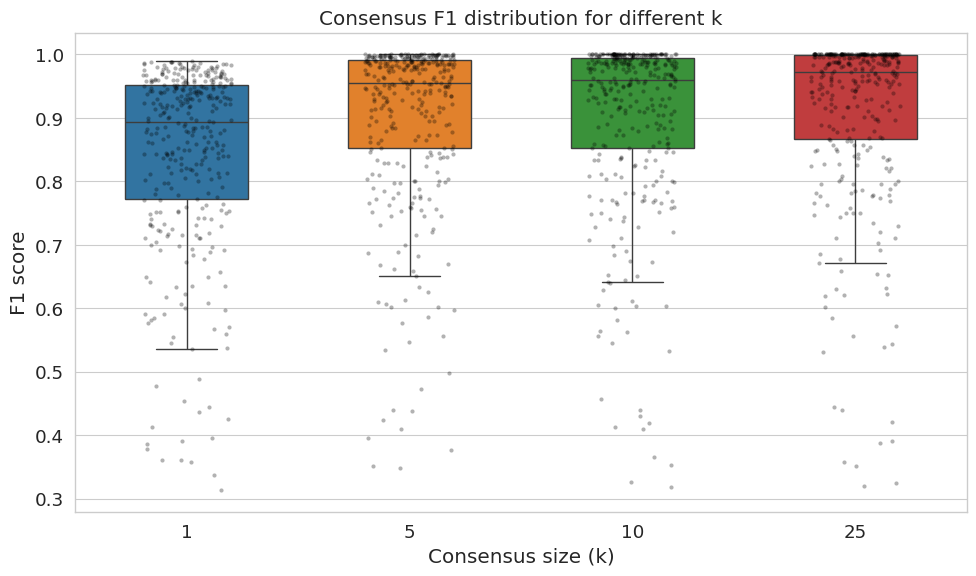

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec

sns.set_context("talk")
sns.set_style("whitegrid")

def plot_consensus_boxplot(df_stats, Ks=[5,10,15,25,50]):
    sns.set_context("paper", font_scale=1.5)
    sns.set_style("whitegrid")

    data = []
    for k in Ks:
        for v in df_stats[f"cons_k{k}_mean"]:
            data.append({"k": k, "F1": v})
    df = pd.DataFrame(data)

    plt.figure(figsize=(10,6))
    
    palette = sns.color_palette("tab10", len(Ks))
    sns.boxplot(
        data=df, x="k", y="F1",
        palette=palette, width=0.55,
        showfliers=False
    )

    sns.stripplot(
        data=df, x="k", y="F1",
        color="black", alpha=0.3, size=3, jitter=0.20
    )

    plt.title("Consensus F1 distribution for different k")
    plt.xlabel("Consensus size (k)")
    plt.ylabel("F1 score")
    plt.tight_layout()
    plt.show()
plot_consensus_boxplot(df_stats, Ks=Ks)
    
def plot_consensus_growth(df_stats, Ks=[5,10,15,25,50]):
    plt.figure(figsize=(8,6))
    means = [df_stats[f"cons_k{k}_mean"].mean() for k in Ks]
    stds  = [df_stats[f"cons_k{k}_std"].mean() for k in Ks]

    plt.plot(Ks, means, marker="o")
    plt.fill_between(Ks, np.array(means)-stds, np.array(means)+stds, alpha=0.2)
    
    plt.xlabel("# Samples in consensus")
    plt.ylabel("Mean F1 with mean std ")
    plt.title("Consensus performance growth (20 trials avg)")
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()
    
    

/tmp/ipykernel_746502/362643711.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


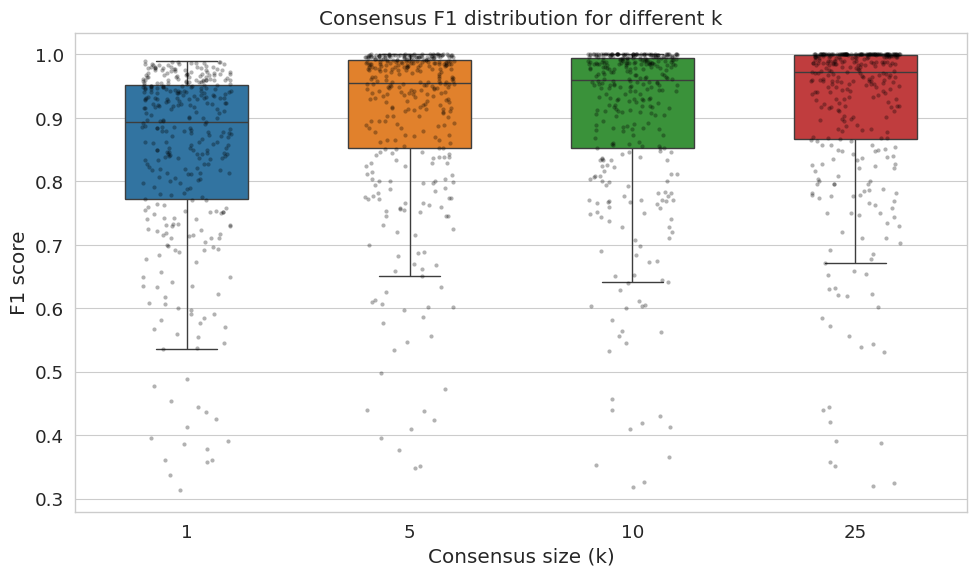

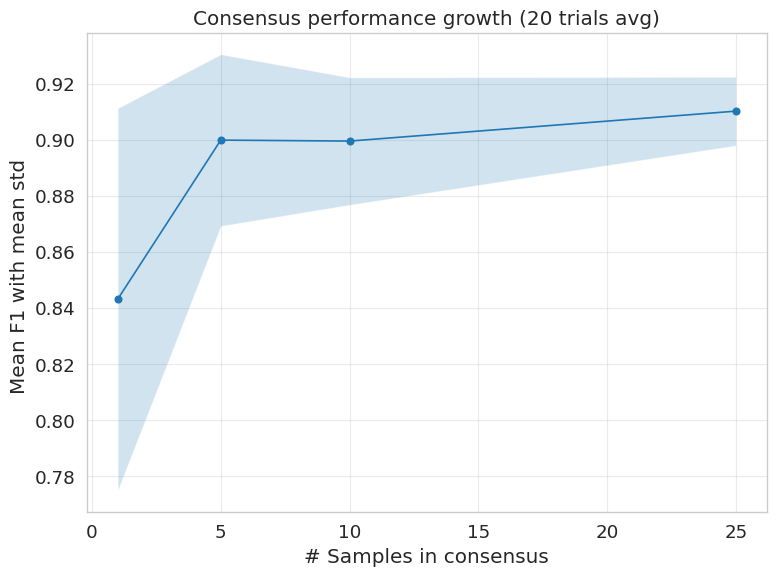

In [ ]:
plot_consensus_boxplot(df_stats, Ks=Ks)
plot_consensus_growth(df_stats, Ks=Ks)  

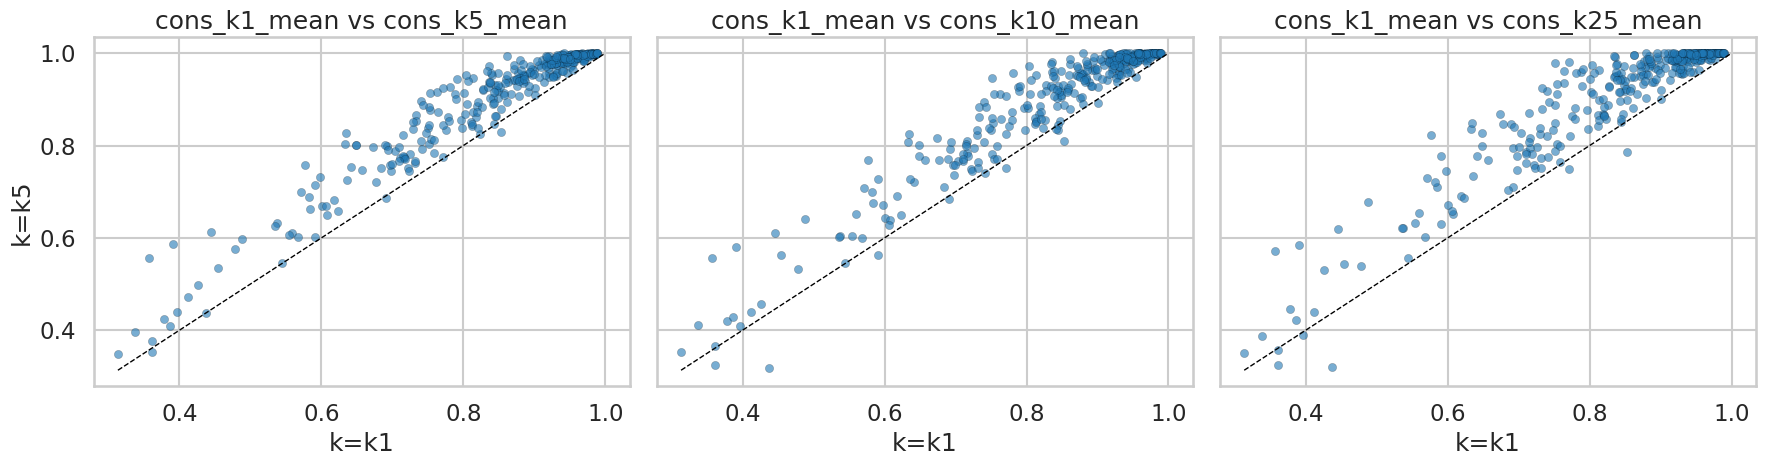

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_context("talk")
sns.set_style("whitegrid")

def plot_multi_scatter(df, x_key, y_keys, title=None):
    """
    Creates a grid of scatterplots comparing one metric (x_key)
    vs multiple metrics (y_keys).
    """
    n = len(y_keys)
    ncols = min(3, n)
    nrows = int(np.ceil(n / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows), sharex=True, sharey=True)
    axes = np.array(axes).reshape(-1) 
    x = df[x_key]

    for ax, y_key in zip(axes, y_keys):
        y = df[y_key]

        sns.scatterplot(
            x=x, y=y, ax=ax,
            s=35, alpha=0.6,
            edgecolor="black", linewidth=0.2 
        )

        # diagonal
        lim_min = min(x.min(), y.min())
        lim_max = max(x.max(), y.max())
        ax.plot([lim_min, lim_max], [lim_min, lim_max], "k--", lw=1)

        ax.set_xlabel(x_key.replace("_mean","").replace("cons_","k="))
        ax.set_ylabel(y_key.replace("_mean","").replace("cons_","k="))
        ax.set_title(f"{x_key} vs {y_key}")

    # Hide empty subplots
    for ax in axes[len(y_keys):]:
        ax.axis("off")

    if title:
        fig.suptitle(title, fontsize=22)
    
    plt.tight_layout()
    plt.show()
    
y_keys = [f"cons_k{k}_mean" for k in Ks[1:]]
plot_multi_scatter(df_stats, x_key="cons_k1_mean", y_keys=y_keys)


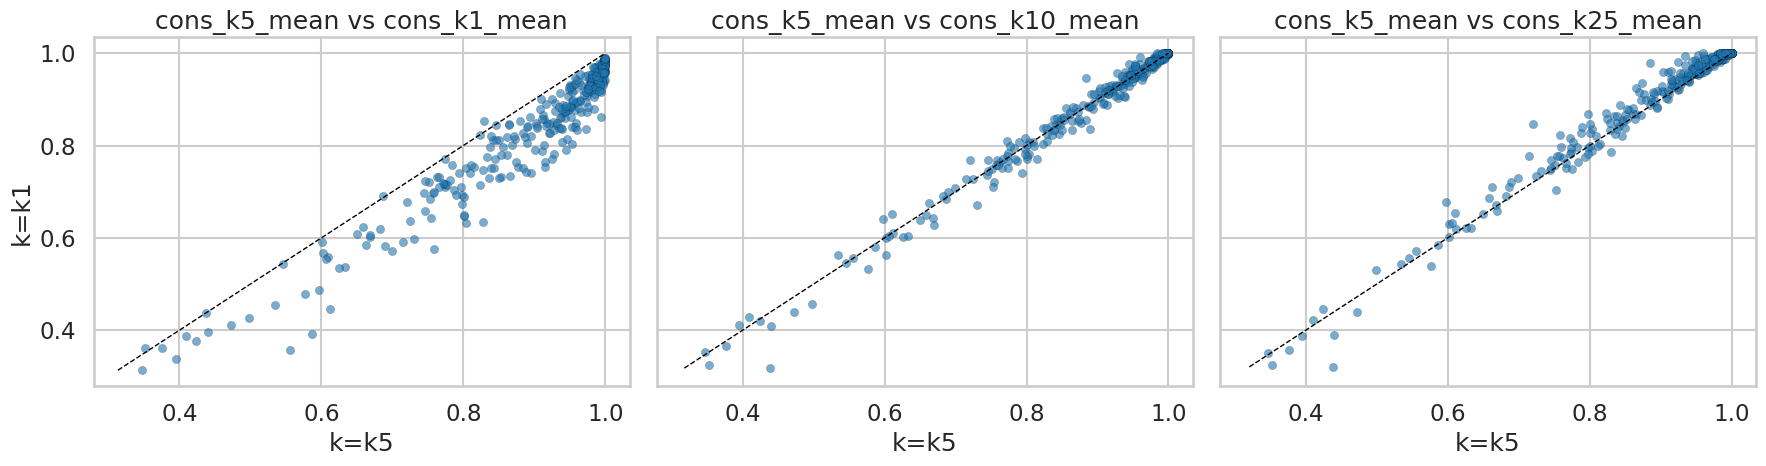

In [ ]:
plot_multi_scatter(df_stats, x_key="cons_k5_mean", y_keys=["cons_k1_mean", "cons_k10_mean","cons_k25_mean"])


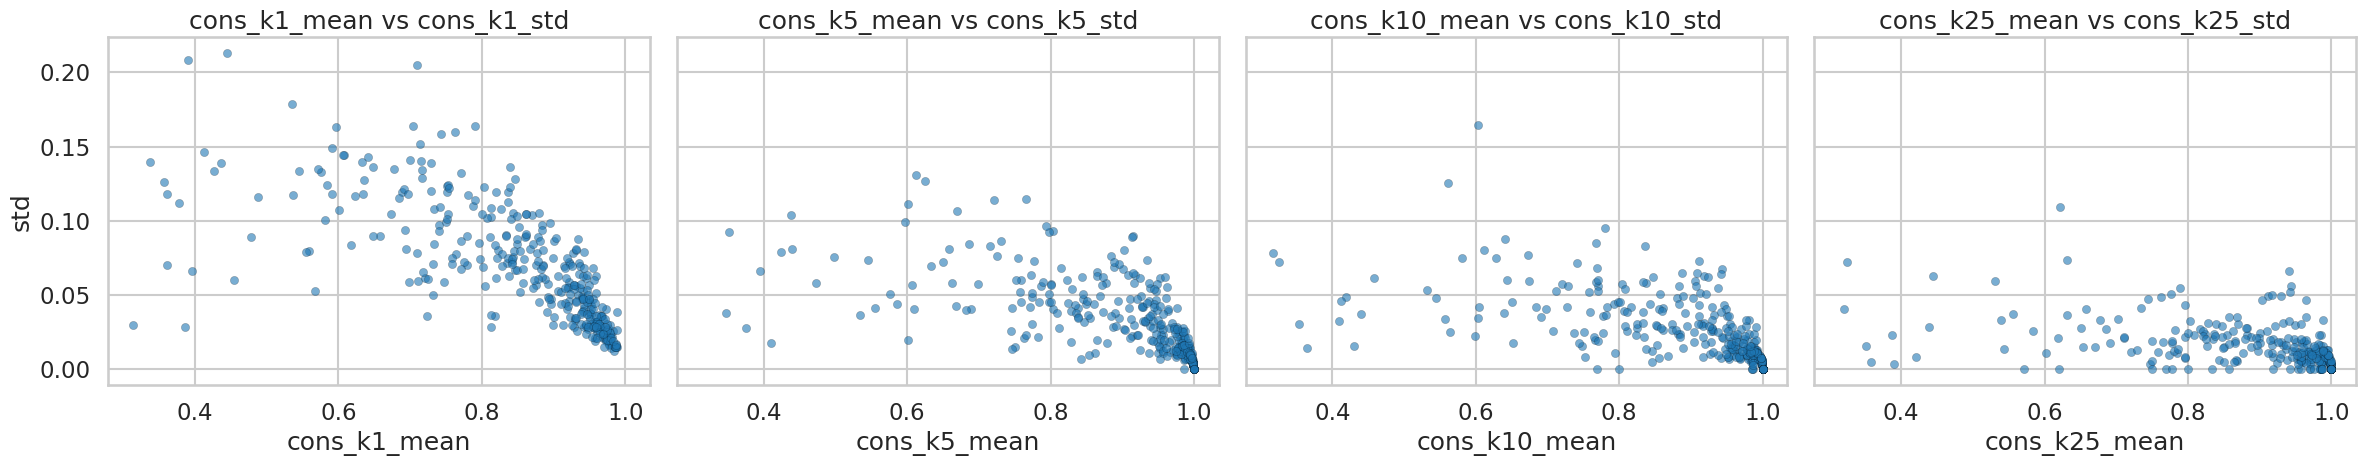

In [ ]:
def plot_multi_scatter_vs_std(df, x_keys, y_keys, title=None):
    """
    Creates a grid of scatterplots comparing one metric (x_key)
    vs multiple metrics (y_keys).
    """
    n = len(y_keys)
    ncols = min(4, n)
    nrows = int(np.ceil(n / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows), sharex=True, sharey=True)
    axes = np.array(axes).reshape(-1) 

    for ax,x_key, y_key in zip(axes, x_keys, y_keys):
        x = df[x_key]
        y = df[y_key]

        sns.scatterplot(
            x=x, y=y, ax=ax,
            s=35, alpha=0.6,
            edgecolor="black", linewidth=0.2, 
        )  
        ax.set_title(f"{x_key} vs {y_key}")

    # Hide empty subplots
    for ax in axes[len(y_keys):]:
        ax.axis("off")
    axes[0].set_ylabel("std")
    if title:
        fig.suptitle(title, fontsize=22)
    
    plt.tight_layout()
    plt.show()
    
x_keys=["cons_k1_mean", "cons_k5_mean","cons_k10_mean", "cons_k25_mean"]
y_keys=["cons_k1_std", "cons_k5_std","cons_k10_std","cons_k25_std"]

plot_multi_scatter_vs_std(df_stats, x_keys=x_keys, y_keys=y_keys)


## Experiments analysis

In [2]:
import re
import pandas as pd
import os

LOGS_PATH = "../logs/"
TRIALS = 20

# Regex to extract T and E from folder names
PATTERN = r"exp_T(\d+)_E(\d+)_"

def parse_exp_name(name):
    m = re.match(PATTERN, name)
    if m:
        T = int(m.group(1))
        E = int(m.group(2))
        return T, E
    return None, None


# Detect experiment folders
ALL_EXPS = [
    exp for exp in os.listdir(LOGS_PATH)
    if os.path.isdir(os.path.join(LOGS_PATH, exp))
]

# Load csvs + parse T/E + rename experiment to "T{T}_E{E}"
EXP_INFO = []
for exp in ALL_EXPS:
    T, E = parse_exp_name(exp)
    if T is None:
        continue

    csv_path = f"{LOGS_PATH}{exp}/enemble_stats_{TRIALS}_trials.csv"
    if not os.path.exists(csv_path):
        continue

    df = pd.read_csv(csv_path)
    short_name = f"T{T}_E{E}"

    EXP_INFO.append({
        "name": short_name,  
        "T": T,
        "E": E,
        "df": df
    })


# ---- Grouping ----

group_by_T = {}
for item in EXP_INFO:
    T = item["T"]
    group_by_T.setdefault(T, {})[item["name"]] = item["df"]

group_by_E = {}
for item in EXP_INFO:
    E = item["E"]
    group_by_E.setdefault(E, {})[item["name"]] = item["df"]


In [4]:
group_by_E[5]["T10_E5"]

,Unnamed: 0,seq_id,cons_k1_mean,cons_k1_std,cons_k2_mean,cons_k2_std,cons_k3_mean,cons_k3_std,cons_k4_mean,cons_k4_std,...,cons_k13_mean,cons_k13_std,cons_k14_mean,cons_k14_std,cons_k15_mean,cons_k15_std,cons_k20_mean,cons_k20_std,cons_k25_mean,cons_k25_std
0,0,5s_Acidovorax-delafieldii-1,0.981906,0.018724,0.991489,0.011512,0.993961,7.397614e-03,0.993169,7.553759e-03,...,0.999254,3.252910e-03,1.000000,0.000000e+00,0.999254,3.252910e-03,1.000000,0.000000e+00,1.000000,0.000000e+00
1,1,5s_Acinetospora-crinita-1,0.986166,0.012365,0.988692,0.010607,0.995833,6.366794e-03,0.997203,7.112839e-03,...,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00
2,2,5s_Acyrthosiphon-magnoliae-1,0.986867,0.018394,0.971561,0.056984,0.998507,4.477612e-03,0.996129,1.383706e-02,...,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00
3,3,5s_Akkesiphycus-lubricum-1,0.984891,0.013610,0.989455,0.010793,0.996517,6.032675e-03,0.997203,7.112839e-03,...,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00
4,4,5s_Alcaligenes-faecalis-3,0.981904,0.006245,0.978003,0.010108,0.985507,2.220446e-16,0.985507,2.220446e-16,...,0.985507,2.220446e-16,0.985507,2.220446e-16,0.985507,2.220446e-16,0.985507,2.220446e-16,0.985507,2.220446e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,343,tRNA_tdbR00000609-Chlamydomonas_reinhardtii-30...,0.809586,0.100755,0.848441,0.082550,0.861805,6.875390e-02,0.862115,6.415495e-02,...,0.903660,6.890621e-02,0.911323,7.036224e-02,0.898255,6.798435e-02,0.868003,4.657233e-02,0.936379,6.597582e-02
344,344,tRNA_tdbR00000612-Sinorhizobium_meliloti-382-T...,0.946270,0.090987,0.919675,0.082484,0.976270,5.508954e-02,0.973805,4.423117e-02,...,1.000000,0.000000e+00,0.996154,1.676500e-02,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00
345,345,tRNA_tdbR00000615-Nanoarchaeum_equitans-160232...,0.937871,0.090183,0.929536,0.061864,0.996512,1.520546e-02,0.995061,1.265284e-02,...,0.998780,5.315730e-03,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00
346,346,tRNA_tdbR00000616-Nanoarchaeum_equitans-160232...,0.932855,0.060420,0.976816,0.034311,0.963014,4.182354e-02,0.986047,1.139298e-02,...,0.979175,1.230991e-02,0.987209,1.156962e-02,0.986047,1.139298e-02,0.986047,1.139298e-02,0.983721,1.065715e-02


In [8]:
import sys 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append("../")

def plot_consensus_growth_multi(dfs, Ks=[5,10,15,25,50], ax=None):
    """Plots consensus F1 growth for multiple experiments in one axis."""
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6), sharey=True)

    # Color palette depending on #exps
    palette = sns.color_palette("tab10", n_colors=len(dfs))

    for (exp_name, df_stats), color in zip(dfs.items(), palette):
        means = np.array([df_stats[f"cons_k{k}_mean"].mean() for k in Ks])
        stds  = np.array([df_stats[f"cons_k{k}_std"].mean() for k in Ks])

        ax.plot(Ks, means, marker="o", color=color, label=exp_name)
        ax.fill_between(Ks, means - stds, means + stds, color=color, alpha=0.15)

    ax.set_xlabel("# Samples in consensus")
    ax.set_ylabel("Mean F1 (± mean std)")
    ax.set_title("Consensus performance growth across experiments")
    ax.grid(True, alpha=0.4)
    ax.legend(title="Experiments", fontsize=9)

    return ax

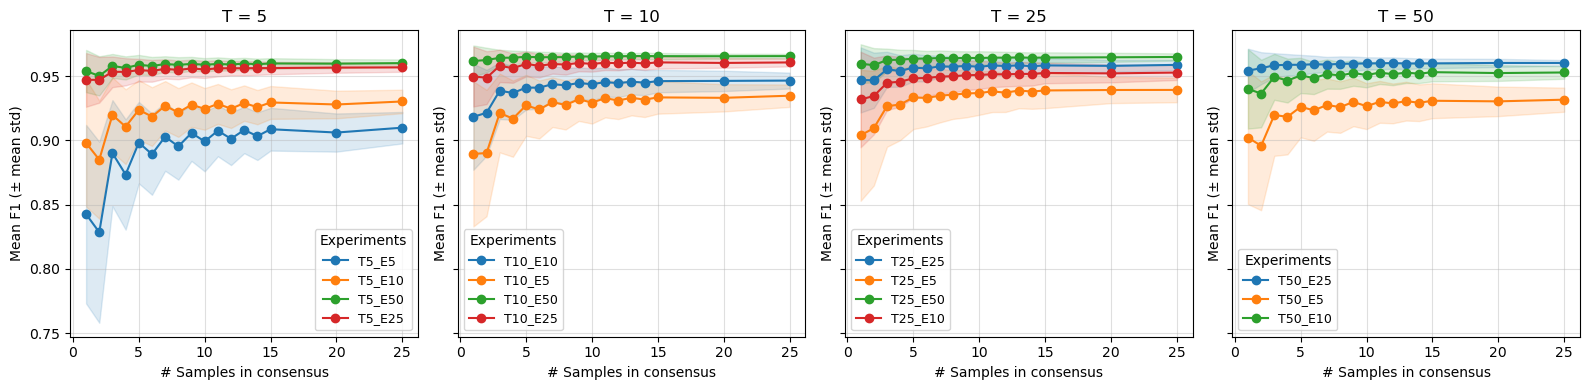

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

params = [5, 10, 25, 50]    

N_CONSENSUS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,13, 14, 15, 20, 25]    
for ax, p in zip(axes, params):
    plot_consensus_growth_multi(
        dfs=group_by_T[p],
        Ks=N_CONSENSUS,
        ax=ax
    )
    ax.set_title(f"T = {p}")

plt.tight_layout()
plt.show()


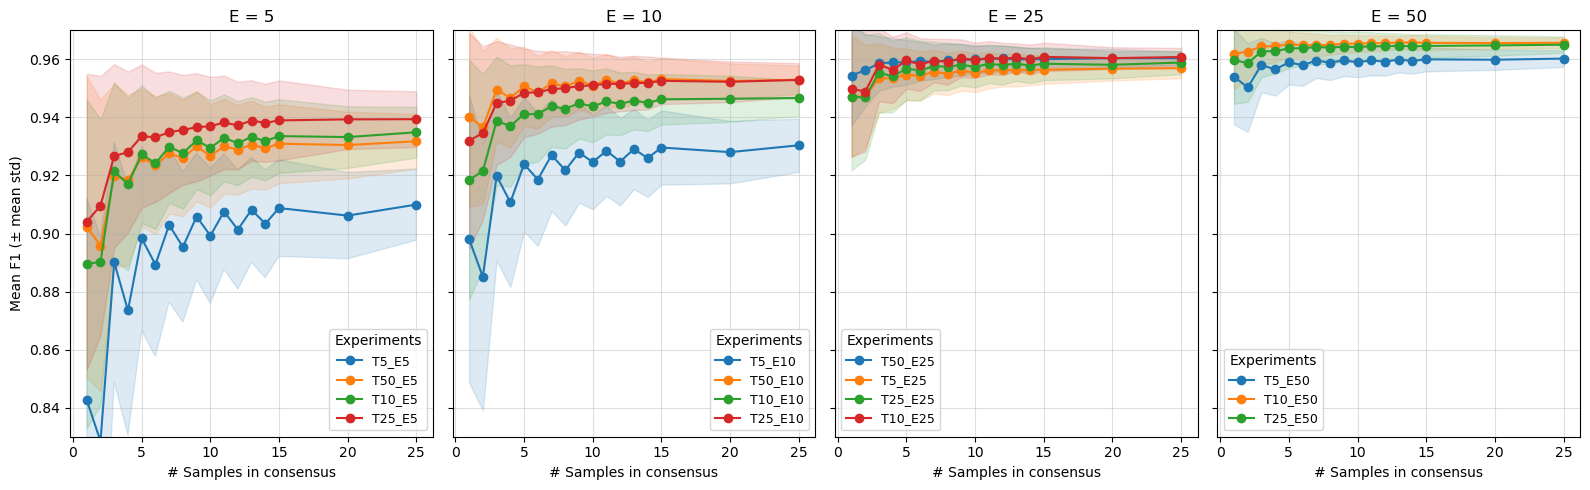

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

params = [5, 10, 25, 50]    

for ax, p in zip(axes, params):
    plot_consensus_growth_multi(
        dfs=group_by_E[p],
        Ks=N_CONSENSUS,
        ax=ax
    )
    ax.set_title(f"E = {p}")
for ax in axes[1:]:
    ax.set_ylabel("")
ax.set_ylim(0.83, 0.97)
plt.tight_layout()
plt.show()


<Figure size 900x600 with 0 Axes>

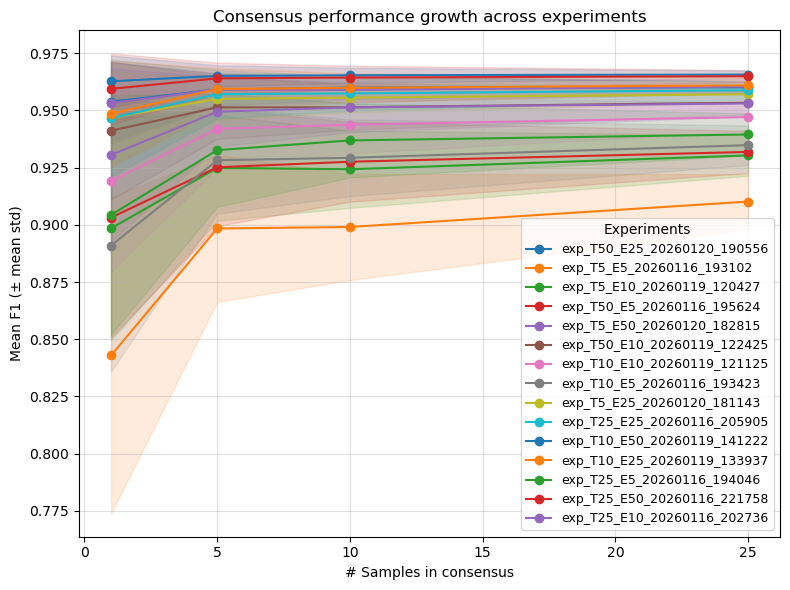

In [ ]:
LOGS_PATH = "../logs/"
TRIALS = 20 
ALL_EXPS = [
    exp for exp in os.listdir(LOGS_PATH) 
    if not exp.endswith(".csv")
]

dfs = {
    exp: pd.read_csv(f"{LOGS_PATH}{exp}/enemble_stats_{TRIALS}_trials.csv")
    for exp in ALL_EXPS
}

plt.figure(figsize=(9, 6))
ax = plot_consensus_growth_multi(dfs, Ks=N_CONSENSUS)
plt.tight_layout()
plt.show()


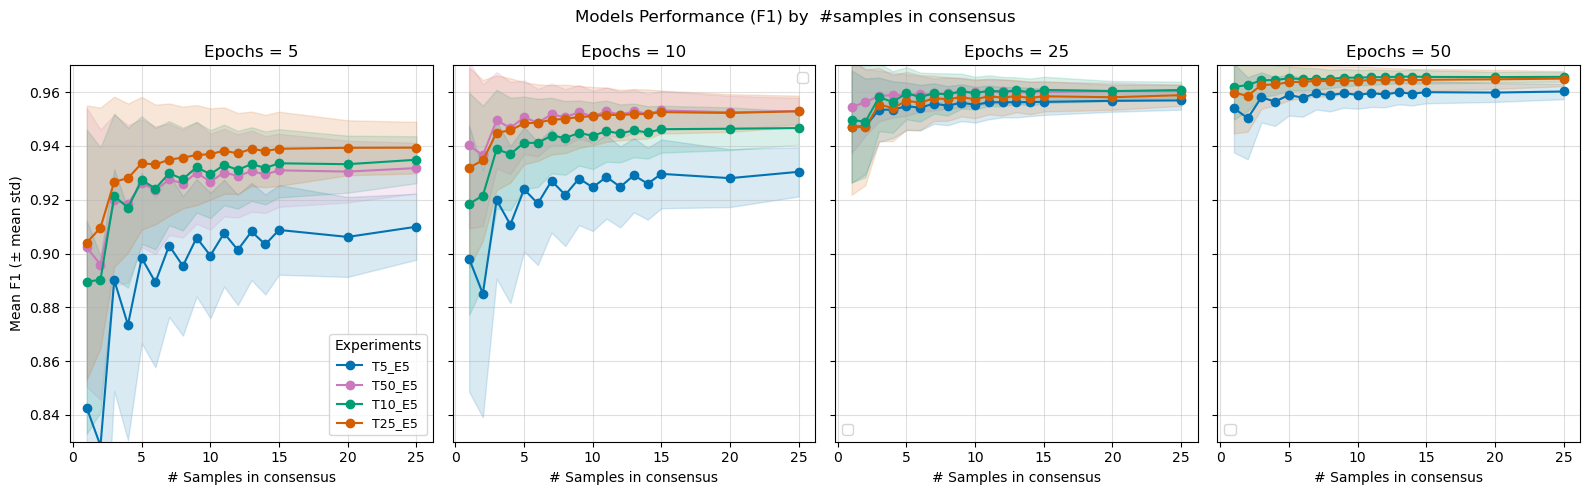

In [25]:
T_values = [5, 10, 25, 50]
T_color_map = {
    T: color
    for T, color in zip(T_values, sns.color_palette("colorblind6", n_colors=len(T_values)))
}
def plot_consensus_growth_multi(dfs, Ks=[5,10,15,25,50], ax=None):
    """Plots consensus F1 growth for multiple experiments in one axis."""
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    for exp_name, df_stats in dfs.items():

        # --- Extract T from name "T{T}_E{E}" ---
        T_val = int(exp_name.split("_")[0].replace("T", ""))
        color = T_color_map[T_val]

        means = np.array([df_stats[f"cons_k{k}_mean"].mean() for k in Ks])
        stds  = np.array([df_stats[f"cons_k{k}_std"].mean() for k in Ks])

        ax.plot(Ks, means, marker="o", color=color, label=exp_name)
        ax.fill_between(Ks, means - stds, means + stds, color=color, alpha=0.15)

    ax.set_xlabel("# Samples in consensus")
    ax.set_ylabel("Mean F1 (± mean std)")
    ax.set_title("Consensus performance growth across experiments")
    ax.grid(True, alpha=0.4)
    ax.legend(title="Experiments", fontsize=9)

    return ax
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

params = [5, 10, 25, 50]    

for ax, p in zip(axes, params):
    plot_consensus_growth_multi(
        dfs=group_by_E[p],  # experiments con el mismo E
        Ks=N_CONSENSUS,
        ax=ax
    )
    ax.set_title(f"Epochs = {p}")

for ax in axes[1:]:
    ax.set_ylabel("")
for ax in axes[1:]:
    ax.legend("")

ax.set_ylim(0.83, 0.97)
fig.suptitle("Models Performance (F1) by  #samples in consensus")
plt.tight_layout()
plt.show()
